[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Goals

Now, let's build up to a simple chain that combines 4 concepts.

* Using [chat messages](https://docs.langchain.com/oss/python/langchain/messages) as our graph state
* Using [chat models](https://docs.langchain.com/oss/python/integrations/chat) in graph nodes
* [Binding tools](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to our chat model
* [Executing tool calls](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

챗 모델은 대화 내 다양한 역할을 포착하는 [메시지](https://docs.langchain.com/oss/python/langchain/messages)를 사용할 수 있습니다. 

LangChain은 `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage` 등 다양한 메시지 유형을 지원합니다.

이들은 각각 사용자의 메시지, 챗 모델의 메시지, 챗 모델의 행동 지시 메시지, 도구 호출 메시지를 나타냅니다.

메시지 목록을 생성해 보겠습니다. 

각 메시지에는 다음 정보가 포함될 수 있습니다:

* `content` - 메시지 내용
* `name` - 메시지 작성자(option)
* `response_metadata` - 메타데이터 딕셔너리(예: `AIMessages`의 경우 모델 제공자가 자주 채움, option)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"그러니까 해양 포유류를 연구하고 있다고 하셨나요?", name="Model")]
messages.append(HumanMessage(content=f"예. 맞습니다.",name="Lance"))
messages.append(AIMessage(content=f"좋아요, 무엇을 배우고 싶으신가요?", name="Model"))
messages.append(HumanMessage(content=f"미국에서 범고래를 관찰하기 가장 좋은 장소에 대해 알고 싶습니다.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

그러니까 해양 포유류를 연구하고 있다고 하셨나요?
================================ Human Message =================================
Name: Lance

예. 맞습니다.
================================== Ai Message ==================================
Name: Model

좋아요, 무엇을 배우고 싶으신가요?
================================ Human Message =================================
Name: Lance

미국에서 범고래를 관찰하기 가장 좋은 장소에 대해 알고 싶습니다.


## Chat Models

챗 모델은 위에서 논의한 바와 같이 메시지 시퀀스를 입력으로 사용하며 메시지 유형을 지원합니다.

선택할 수 있는 모델이 [많습니다](https://docs.langchain.com/oss/python/integrations/chat)! OpenAI와 함께 작업해 보겠습니다.


In [3]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

from dotenv import load_dotenv

load_dotenv("../../.env")

True

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='미국에서 범고래를 관찰하기 좋은 장소는 여러 곳이 있습니다. 그 중 일부는 다음과 같습니다:\n\n1. **알래스카**: 알래스카 근해에서는 범고래의 주요 서식지가 있습니다. 특히, 카트마이즈 해협이나 딘 섬 근처에서 범고래를 관찰할 수 있습니다.\n\n2. **워싱턴주**: 특히, 오레곤 성역 제도 주변의 퓨젯 사운드(Puget Sound) 지역에서 범고래를 관찰할 수 있습니다. 퓨젯 사운드에서는 범고래가 자주 나타납니다. 특히 "Southern Resident" 범고래 팩이 이 지역에서 자주 발견됩니다.\n\n3. **캘리포니아**: 몬터레이 베이(Monterey Bay)와 같은 곳에서도 범고래를 관찰할 수 있습니다. 이곳에서는 여름과 가을에 범고래가 많이 나타납니다.\n\n4. **하와이**: 하와이에서는 겨울철에 범고래의 Migration이 이루어지며, 하와이섬 주변에서 관찰할 수 있습니다.\n\n각 지역에서의 범고래 관찰은 계절 및 환경에 따라 달라질 수 있으므로 방문 시기를 잘 계획하는 것이 중요합니다. 추가 정보가 필요하시면 언제든지 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 299, 'prompt_tokens': 79, 'total_tokens': 378, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 299,
  'prompt_tokens': 79,
  'total_tokens': 378,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_provider': 'openai',
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_bd4be55b21',
 'id': 'chatcmpl-DA90zmMdXRvgVnPQV9DzjBAdAXLsx',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

도구는 모델이 외부 시스템과 상호작용해야 할 때 유용합니다.

외부 시스템(예: API)은 자연어 대신 특정 입력 스키마나 페이로드를 요구하는 경우가 많습니다.

예를 들어 API를 도구로 바인딩하면, 모델이 필요한 입력 스키마를 인식하도록 합니다.

모델은 사용자의 자연어 입력을 기반으로 도구를 호출할지 선택합니다. 

그리고 해당 도구의 스키마를 준수하는 출력을 반환합니다.

[많은 LLM 제공업체가 도구 호출을 지원하며](https://docs.langchain.com/oss/python/integrations/chat) LangChain의 [도구 호출 인터페이스](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/)는 간단합니다. 
 
Python `function`을 `ChatModel.bind_tools(function)` 형태로 전달하기만 하면 됩니다.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

입력값(예: `“2에 3을 곱하면 얼마인가요?”`)을 전달하면 도구 호출이 반환됩니다.

도구 호출에는 호출할 함수 이름과 함께 함수의 입력 스키마에 맞는 특정 인수가 포함됩니다.

```
{‘arguments’: ‘{“a”:2,“b”:3}’, ‘name’: ‘multiply’}
```

In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"곱하기 3은 얼마입니까?", name="Lance")])

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 3},
  'id': 'call_zTOSzLePSekYNXuGvZYOdCeD',
  'type': 'tool_call'}]

In [10]:
tool_call

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_2d82c05f26', 'id': 'chatcmpl-DA9142VW4gl9hTfuIjZ3A2Z3DnomD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c6a52-5826-7393-8b4d-637a9b3df42f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_zTOSzLePSekYNXuGvZYOdCeD', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 64, 'output_tokens': 17, 'total_tokens': 81, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Using messages as state

이러한 기반이 마련되었으므로 이제 그래프 state에서 [메시지](https://docs.langchain.com/oss/python/langchain/overview#messages)를 사용할 수 있습니다.

`MessagesState` 상태를 단일 키 `messages`를 가진 `TypedDict`로 정의해 보겠습니다.

`messages`는 위에서 정의한 대로 단순히 메시지 목록입니다(예: `HumanMessage` 등).

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

문제가 생겼습니다!

앞서 논의한 대로, 각 노드는 상태 키 `messages`에 대한 새 값을 반환합니다.

하지만 이 새 값이 기존 `messages` 값을 덮어쓸 것입니다!
 
그래프가 실행될 때, 우리는 `messages` 상태 키에 메시지를 **추가**하고 싶습니다.
 
이를 해결하기 위해 [리듀서 함수](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers)를 사용할 수 있습니다.

리듀서는 상태 업데이트가 수행되는 방식을 지정합니다.

리듀서 함수가 지정되지 않으면, 앞서 본 것처럼 키에 대한 업데이트가 *키를 덮어쓰는* 것으로 간주됩니다.
 
하지만 메시지를 추가하려면 미리 구축된 `add_messages` 리듀서를 사용할 수 있습니다.

이렇게 하면 모든 메시지가 기존 메시지 목록에 추가됩니다.

`messages` 키에 `add_messages` 리듀서 함수를 메타데이터로 주석 처리하기만 하면 됩니다.

In [12]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

그래프 상태에 메시지 목록을 포함하는 것이 매우 흔하기 때문에, LangGraph에는 미리 구축된 [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)가 있습니다! 

`MessagesState`는 다음과 같이 정의됩니다:

* 미리 구축된 단일 `messages` 키로 구성
* `AnyMessage` 객체들의 리스트 형태
* `add_messages` 리듀서를 사용

위에서 보여준 것처럼 커스텀 `TypedDict`를 정의하는 것보다 덜 장황하기 때문에 일반적으로 `MessagesState`를 사용할 것입니다.

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # 여기에 추가 키를 정의할 수도 있음
    pass

좀 더 깊이 들어가서, `add_messages` 리듀서가 독립적으로 어떻게 작동하는지 살펴볼 수 있습니다.

In [13]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e2ae0775-5a1a-4a24-94ac-0171b60cc36b', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='ab8823f4-96c3-4393-854a-e172dd9bac73'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='a07bf0f6-5083-4011-b6cc-f22cf0e4d0b1', tool_calls=[], invalid_tool_calls=[])]

## Our graph

Now, lets use `MessagesState` with a graph.

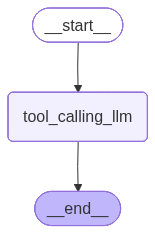

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [15]:
messages = graph.invoke({"messages": HumanMessage(content="안녕하세요!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

안녕하세요!
================================== Ai Message ==================================

안녕하세요! 어떻게 도와드릴까요?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="2 곱하기 3은?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

2 곱하기 3은?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZXJdXzSY1B7qzItxB8Ut8YCq)
 Call ID: call_ZXJdXzSY1B7qzItxB8Ut8YCq
  Args:
    a: 2
    b: 3


- AI 메시지는 도구 호출 정보임